In [5]:
using CairoMakie
using DelimitedFiles, Statistics, Glob, LaTeXStrings, StatsBase, LinearAlgebra, SparseArrays, Distances, LazySets;
using Measures: mm
include("final_analysis_library.jl");

In [6]:
#simulation params
L = 8
N = 128
M = 100
B = 1;
nu = 0.005;
Delta = 4.;
F0 = 1.; 

K = 4
pk = 0.2

folder = "../data/Delta$(Delta)_F0$(F0)_nu$(nu)_N$(N)_M$(M)_B$(B)_L$(L)/half_fixed/long_K$(K)_pk$(pk)/";

sfolder = folder*"zeros/sample_1/"
fieldmatrix = readdlm(sfolder*"fieldmatrix.txt",header=true)[1][:,2:end];

means = mean(fieldmatrix,dims=1)
vars = var(fieldmatrix,dims=1)


ncopies = 100
tini = 75
nsteps = 200
dt = 50;

In [7]:
#histograms

ncopies = 100

tini = 75
nsteps = 200
dt = 50

N = 128

folder = "../data/Delta$(Delta)_F0$(F0)_nu$(nu)_N$(N)_M$(M)_B$(B)_L$(L)/half_fixed/long_K$(K)_pk$(pk)/";

popX,popV = prf(folder,"saved_snaps",tini,nsteps,ncopies,dt);
popX_ref,popV_ref = prf(folder,"saved_snaps_ref",tini,nsteps,ncopies,dt);

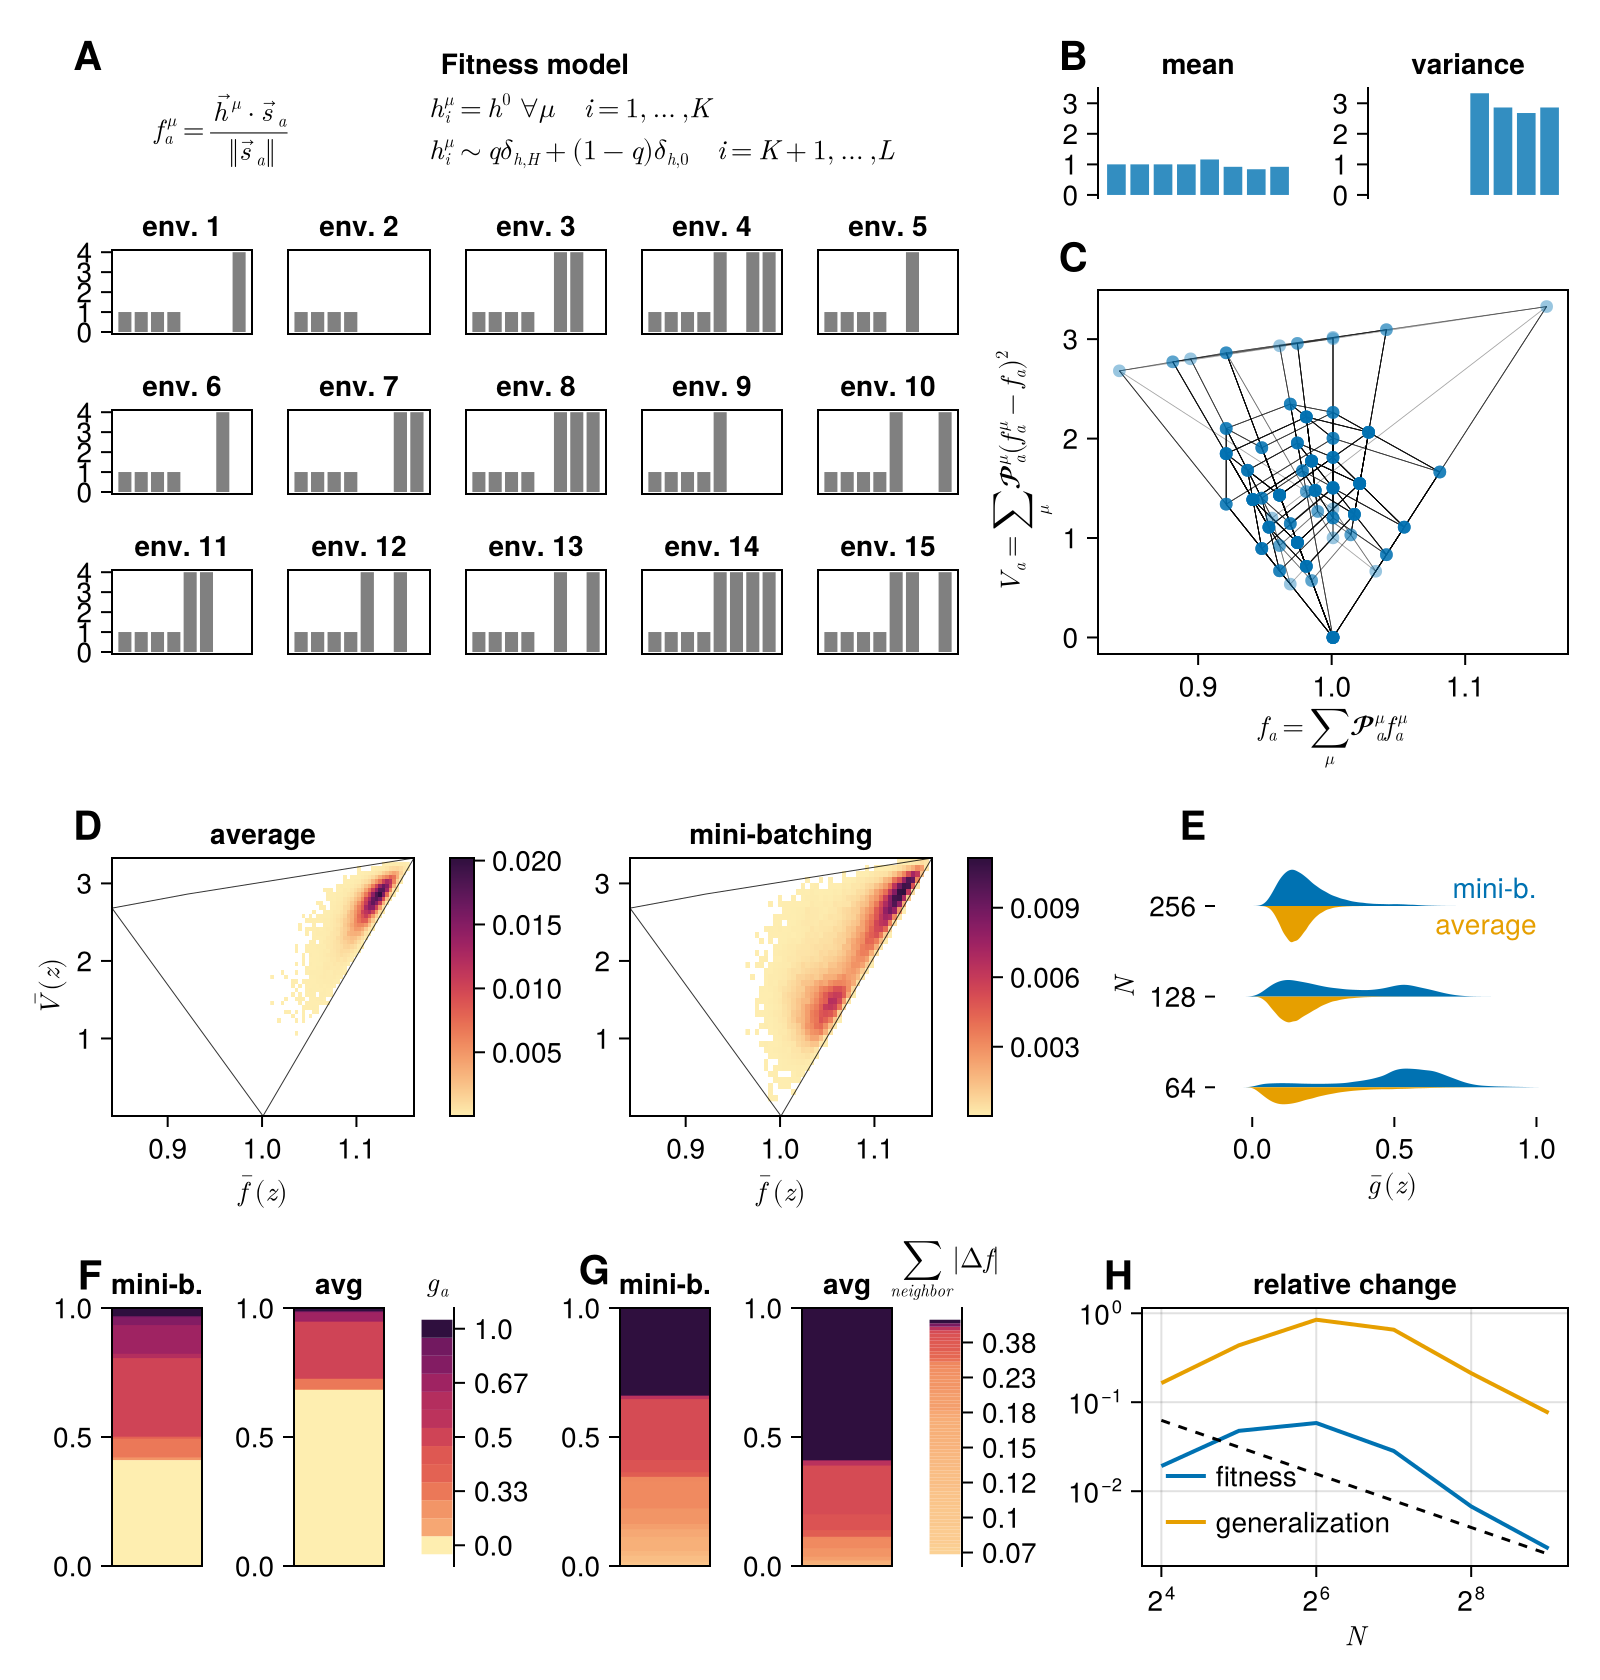

In [8]:
f = Figure(size = (800, 840))

h = 600
w = 900

gabc = f[1, 1:2] = GridLayout()
ga = gabc[1,1] = GridLayout()
gbc = gabc[1,2] = GridLayout()
gb = gbc[1,1] = GridLayout()
gc = gbc[2,1] = GridLayout()
gdefgh = f[2, 1:2] = GridLayout()
gdef = gdefgh[1,1:2]  = GridLayout()
gd = gdef[1, 1] = GridLayout()
gef = gdef[1, 2] = GridLayout()
ge = gef[1,1] = GridLayout()
#gf = gef[1,2] = GridLayout()
ggh = gdefgh[2,1:2] = GridLayout()
gg  = ggh[1,1] = GridLayout()
gflat = gg[1,2] = GridLayout()
gflat_plot = gflat[1,1] = GridLayout()
ggen = gg[1,1] = GridLayout()
ggen_plot = ggen[1,1] = GridLayout()
gh = ggh[1,2] = GridLayout()

#######################
#Panel A
#######################

nrows = 3
ncols = 5
axs = [Axis(ga[row, col],
        xgridvisible = false,
        ygridvisible = false,
        limits=(nothing,(-0.1,4.11))) for row in 2:nrows+1, col in 1:ncols]

hidedecorations!.(axs, grid = false, label = false)

#get individual landscapes
grp = [findall(==(r),eachrow(fieldmatrix)) for r in unique(eachrow(fieldmatrix))]       
uniques = collect(zip(length.(grp), first.(grp)))

P = []
unique_landscapes = []
for i=1:size(uniques)[1]
    push!(unique_landscapes,fieldmatrix[uniques[i][2],:])
end


for row in 1:nrows, col in 1:ncols
    i = Int(1+(row-1)*ncols + col-1)
    barplot!(axs[row, col],unique_landscapes[i],color=:gray,alpha=0.9)
    axs[row, col].title="env. $i"
    axs[row,1].yticksvisible = true
    axs[row,1].yticklabelsvisible = true
end  

at = Axis(ga[1,1:ncols],xgridvisible = false,ygridvisible = false, limits=((-1,1),(-1,1)))
hidedecorations!(at, grid = false, label = false)
hidespines!(at)
at.title = "Fitness model"
text!(at,-0.9,0,text=L"f_a^{\mu} = \frac{\vec{h}^\mu \cdot \vec{s}_a}{\Vert \vec{s}_a \Vert}",align=(:left,:center))
text!(at,-0.25,0.5,text=L"h_i^{\mu} = h^0\ \forall \mu \quad i = 1,\dots, K",align=(:left,:center))
text!(at,-0.25,-0.5,text=L"h_i^{\mu} \sim q\delta_{h,H} + (1-q)\delta_{h,0} \quad i = K+1,\dots, L",align=(:left,:center))

#######################
#panel B
#######################

axm = Axis(gb[1, 1],xgridvisible = false,ygridvisible = false,title="mean", limits=(nothing,(-0.1,3.5)))
axv = Axis(gb[1, 2],xgridvisible = false,ygridvisible = false,title="variance", limits=(nothing,(-0.1,3.5)))

hidedecorations!.(axm, grid = false, label = false)
hidedecorations!.(axv, grid = false, label = false)

barplot!(axm,means[1,:])
barplot!(axv,vars[1,:])

axm.yticksvisible = true
axm.yticklabelsvisible = true
axv.yticksvisible = true
axv.yticklabelsvisible = true

hidespines!(axm, :t, :r, :b)
hidespines!(axv, :t, :r, :b)

#######################
#panel C
#######################

pgraph = Axis(gc[1,1],xgridvisible = false,ygridvisible = false)
sfolder = folder*"zeros/sample_1/"
fieldmatrix = readdlm(sfolder*"fieldmatrix.txt",header=true)[1][:,2:end]
means = mean(fieldmatrix,dims=1)
vars = var(fieldmatrix,dims=1)
F,V,G = get_FVG(means,vars,L,K)

for spec in 0:2^L-1
    seq = digits(spec,base=2,pad=L)
    onehot = Matrix(I, L, L)
    neighs = [(seq .+ onehot[:,k]).%2 for k in 1:L]
    ngh = [bin_to_int(neighs[k]) for k in 1:L]
    for k in 1:L
        lines!(pgraph,[F[spec+1],F[ngh[k]+1]],[V[spec+1],V[ngh[k]+1]],linewidth=0.4,alpha=0.2,color=:black) 
    end
end

scatter!(pgraph,F,V,alpha=0.4)
t = map(F, V) do xi, yi
           [xi, yi]
    end;
ch = convex_hull(t)
C = reduce(hcat,ch)

pgraph.xlabel = L"f_a = \sum_\mu \mathcal{P}_a^\mu f_a^\mu"
pgraph.ylabel = L"V_a = \sum_\mu \mathcal{P}_a^\mu (f_a^\mu - f_a)^2"

#######################
#Panel D
#######################

H2 = Axis(gd[1, 3],xgridvisible = false,ygridvisible = false)
H1 = Axis(gd[1, 1],xgridvisible = false,ygridvisible = false)

H2.title = "mini-batching"
H1.title = "average"

nbins = 40

x_mids, y_mids, counts = hist2d(popX,popV,nbins)
hm2 = heatmap!(H2,x_mids,y_mids,counts,colormap=cgrad(:matter))

x_mids, y_mids, counts = hist2d(popX_ref,popV_ref,nbins)
hm1 = heatmap!(H1,x_mids,y_mids,counts,colormap=cgrad(:matter))

lines!(H2,push!(C[1,:],C[1,1]),push!(C[2,:],C[2,1]),color=:black,alpha=0.8,linewidth=0.5)
lines!(H1,push!(C[1,:],C[1,1]),push!(C[2,:],C[2,1]),color=:black,alpha=0.8,linewidth=0.5)

Colorbar(gd[1,2],hm1)
Colorbar(gd[1,4],hm2)

H1.xlabel = L"\bar{f}(z)"
H2.xlabel = L"\bar{f}(z)"
H1.ylabel = L"\bar{V}(z)"

#######################
#Panel H
#######################

pref = "../data/persistent/Delta$(Delta)_F0$(F0)_nu$(nu)_"
postf = "_M100_B1_L$(L)_pers0.0/half_fixed/long_K$(K)_pk$(pk)/"
Narr = 2 .^range(4,9)
lN = length(Narr);

Favg = zeros(lN)
Gavg = zeros(lN)
Fref = zeros(lN)
Gref = zeros(lN)

Gdist = Vector{Float64}()
GRdist = Vector{Float64}()
j=1
inits = ["zeros/","ones/","rand1/","rand2/","rand3/","rand4/","rand5/"]
for N in Narr
    folder = pref*"N$(N)"*postf
    for init_cond in inits
        favg,gavg,fref,gref,fdist,gdist,fr_dist,gr_dist = get_means_distr(folder*init_cond, ncopies, tini)
        Favg[j] += favg
        Gavg[j] += gavg
        Fref[j] += fref
        Gref[j] += gref
        if 64<=N<=256
            append!(Gdist,gdist./N)
            append!(GRdist,gr_dist./N)
        end
    end
    j+=1
end
den = Narr*length(inits)
Favg ./= den
Gavg ./= den
Fref ./= den
Gref ./= den;    



axb = Axis(gh[1,1],xscale=log2,yscale=log10)
lines!(axb,Narr,abs.(Favg.-Fref).*2 ./(Favg.+Fref),label="fitness",linewidth=2)
lines!(axb,Narr,abs.(Gavg.-Gref).*2 ./(Gavg.+Gref),label="generalization",linewidth=2)
lines!(axb,Narr,1 ./Narr,linestyle=:dash,color=:black)#,label="1/N")
axb.xlabel=L"N" 
axb.title="relative change"
axislegend(axb,position=:lb,framevisible = false)

#######################
#Panel E
#######################

axd = Axis(ge[1,1],xgridvisible = false,ygridvisible = false)
categories = vec(ones(length(inits)*(nsteps-tini+1)*ncopies,1) * Narr[3:5]')
categories = log2.(categories).-6
viol1 = violin!(axd,categories, side=:right, Gdist, label="mini-b.",orientation=:horizontal,color=Makie.wong_colors()[1])
viol2 = violin!(axd,categories, side=:left, GRdist, label="avg",orientation=:horizontal,color=Makie.wong_colors()[2])
axd.yticks=(log2.(Narr[3:5]).-6,string.(Narr[3:5]))
#axislegend(axd,position=:rt,framevisible = false)
text!(axd,1,2.2,text="mini-b.",align=(:right,:center),color=Makie.wong_colors()[1])
text!(axd,1,1.8,text="average",align=(:right,:center),color=Makie.wong_colors()[2])
axd.ylabel=L"N"
axd.xlabel=L"\bar{g}(z)"
hidespines!(axd)

#######################
#Panel F
#######################
N = 128
folder = "../data/persistent/Delta$(Delta)_F0$(F0)_nu$(nu)_N$(N)_M$(M)_B1_L$(L)_pers0.0/half_fixed/long_K$(K)_pk$(pk)/";
ab,ab_ref, genab, genab_ref, uni_list, gen_uni = panelF(folder,F,G,N,ncopies,L,nsteps,tini,dt)

axflat = [Axis(gflat_plot[1,k]) for k in 1:2]
axgen = [Axis(ggen_plot[1,k]) for k in 1:2]
[hidexdecorations!(axflat[k]) for k in 1:2]
[hidexdecorations!(axgen[k]) for k in 1:2]


colsort = sort(uni_list)
absorted = cumsum(ab[sortperm(uni_list)]./7)
ref_absorted = cumsum(ab_ref[sortperm(uni_list)]./7)
band!(axflat[1],[0,1],zeros(2),ones(2).*absorted[1],color=cgrad(:matter)[colsort[1]/colsort[end]])
band!(axflat[2],[0,1],zeros(2),ones(2).*ref_absorted[1],color=cgrad(:matter)[colsort[1]/colsort[end]])
for i in 2:length(absorted)
    band!(axflat[1],[0,1],ones(2).*absorted[i-1],ones(2).*absorted[i].+0.01,color=cgrad(:matter)[colsort[i]/colsort[end]],overdraw=true)
    band!(axflat[2],[0,1],ones(2).*ref_absorted[i-1],ones(2).*ref_absorted[i].+0.01,color=cgrad(:matter)[colsort[i]/colsort[end]],overdraw=true)
end
[ylims!(axflat[k],0,1) for k in 1:2]
[xlims!(axflat[k],0,1) for k in 1:2]
axflat[1].title = "mini-b."
axflat[2].title = "avg"

cb = Axis(gflat[1,2],xgridvisible = false,ygridvisible = false, yaxisposition=:right)
hidedecorations!.(cb, grid = false, label = false)
cb.yticksvisible = true
cb.yticklabelsvisible = true
for k in 1:length(colsort)
    band!(cb,[1,2], ones(2)*(k-1), ones(2)*k,color=cgrad(:matter)[colsort[k]./colsort[end]],overdraw=true)
end
cb.title=L"\sum_{neighbor} |\Delta f|"
cb.yticks = 0.5:10:68.5
labels = string.(round.(colsort[begin:10:end],digits=2))
cb.ytickformat = yvalues -> [labels[Int(1 + (x-0.5)/10)] for x in yvalues]
hidespines!(cb, :t, :l, :b)


#######################
#Panel G
#######################

gen_colsort = sort(gen_uni)
gen_absorted = cumsum(genab[sortperm(gen_uni)]./7)
ref_genabsorted = cumsum(genab_ref[sortperm(gen_uni)]./7)
band!(axgen[1],[0,1],zeros(2),ones(2).*gen_absorted[1],color=cgrad(:matter)[gen_colsort[1]/gen_colsort[end]])
band!(axgen[2],[0,1],zeros(2),ones(2).*ref_genabsorted[1],color=cgrad(:matter)[gen_colsort[1]/gen_colsort[end]])
for i in 2:length(gen_absorted)
    band!(axgen[1],[0,1],ones(2).*gen_absorted[i-1],ones(2).*gen_absorted[i].+0.01,color=cgrad(:matter)[gen_colsort[i]/gen_colsort[end]],overdraw=true)
    band!(axgen[2],[0,1],ones(2).*ref_genabsorted[i-1],ones(2).*ref_genabsorted[i].+0.01,color=cgrad(:matter)[gen_colsort[i]/gen_colsort[end]],overdraw=true)
end
[ylims!(axgen[k],0,1) for k in 1:2]
[xlims!(axgen[k],0,1) for k in 1:2]
axgen[1].title = "mini-b."
axgen[2].title = "avg"

cb_gen = Axis(ggen[1,2],xgridvisible = false,ygridvisible = false, yaxisposition=:right)
hidedecorations!.(cb_gen, grid = false, label = false)
cb_gen.yticksvisible = true
cb_gen.yticklabelsvisible = true
for k in 1:length(gen_colsort)
    band!(cb_gen,[1,2], ones(2)*(k-1), ones(2)*k,color=cgrad(:matter)[gen_colsort[k]./gen_colsort[end]],overdraw=true)
end

cb_gen.title=L"g_a"
cb_gen.yticks = 0.5:3:13.5
gen_labels = string.(round.(gen_colsort[begin:3:end],digits=2))
cb_gen.ytickformat = yvalues -> [gen_labels[Int(1 + (x-0.5)/3)] for x in yvalues]
hidespines!(cb_gen, :t, :l, :b)


for (label, layout) in zip(["A", "B", "C", "D", "E", "G", "F", "H"], [ga, gb,gc, gd, gef, gflat, ggen, gh])
    Label(layout[1, 1, TopLeft()], label,
        fontsize = 20,
        font = :bold,
        padding = (0, 5, 5, 0),
        halign = :right)
end


colsize!(gabc, 1, Auto(1.8))
rowsize!(gbc, 1, Auto(0.3))
colsize!(gdef, 1, Auto(2.5))
colsize!(gef, 1, Auto(5))
rowsize!(f.layout, 1, Auto(0.8))
colsize!(ggh, 1, Auto(2))
rowsize!(gdefgh, 1, Auto(1))
colsize!(gflat, 1, Auto(8))
colsize!(ggen, 1, Auto(8))

save("../data/plots/alt_fig2.pdf",f)
f

